# 1.0 Analyzing Public Facilities Accessibility

## Metric: Public facilities per square mile by neighborhood

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

## 1.1 Load datasets

In [7]:
# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set up absolute paths
project_root = Path('/Users/valimir7/dev/pitt/cmpinf0010/final')
data_dir = project_root / 'data/'
docs_dir = project_root / 'docs/'

# Create directories if they don't exist
data_dir.mkdir(parents=True, exist_ok=True)
docs_dir.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {data_dir}")
print(f"Docs directory: {docs_dir}")

print("\n1. Loading datasets...")

facilities_df = pd.read_csv(str(data_dir / 'facilities.csv'))
print(f"loaded {len(facilities_df):,} facility records")

neighborhoods_df = pd.read_csv(str(data_dir / 'neighborhoods.csv'))
print(f"loaded {len(neighborhoods_df):,} neighborhoods")

Data directory: /Users/valimir7/dev/pitt/cmpinf0010/final/data
Docs directory: /Users/valimir7/dev/pitt/cmpinf0010/final/docs

1. Loading datasets...
loaded 412 facility records
loaded 90 neighborhoods


## 1.2 Explore the data

In [8]:
print("\n2. Exploring data structure...")
print("\nFacilities dataset columns:")
print(facilities_df.columns.tolist())

print("\nNeighborhood dataset columns:")
print(neighborhoods_df.columns.tolist())

print("\nSample facility records:")
print(facilities_df[['name', 'neighborhood', 'type', 'primary_user', 'inactive']].head(15))

print("\nFacility type distribution:")
print(facilities_df['type'].value_counts())

print("\nActive vs Inactive:")
print(facilities_df['inactive'].value_counts())


2. Exploring data structure...

Facilities dataset columns:
['_id', 'id', 'parcel_id', 'inactive', 'name', 'rentable', 'type', 'primary_user', 'address_number', 'street', 'zip', 'image', 'neighborhood', 'council_district', 'ward', 'tract', 'public_works_division', 'pli_division', 'police_zone', 'fire_zone', 'latitude', 'longitude']

Neighborhood dataset columns:
['_id', 'objectid', 'fid_blockg', 'statefp10', 'countyfp10', 'tractce10', 'blkgrpce10', 'geoid10', 'namelsad10', 'mtfcc10', 'funcstat10', 'aland10', 'awater10', 'intptlat10', 'intptlon10', 'shape_leng', 'fid_neighb', 'pghdb_sde_neighborhood_2010_area', 'perimeter', 'neighbor', 'neighbor_i', 'hood', 'hood_no', 'acres', 'sqmiles', 'dpwdiv', 'unique_id', 'sectors', 'shape_le_1', 'shape_ar_1', 'page_number', 'plannerassign', 'globalid', 'created_user', 'created_date', 'last_edited_user', 'last_edited_date', 'temp', 'shape_area', 'shape_length']

Sample facility records:
                                                 name        

## 1.3 Clean the data

In [9]:
# clean data
print("\n3. Cleaning data...")

# Remove inactive facilities
facilities_df = facilities_df[facilities_df['inactive'] == 'f']
print(f"removed inactive facilities: {len(facilities_df):,} active facilities remaining")

# Remove records with missing neighborhood
facilities_df = facilities_df.dropna(subset=["neighborhood"])
print(f"removed facilities without neighborhood: {len(facilities_df):,} facilities remaining")

# Standardize neighborhood names
facilities_df['neighborhood'] = facilities_df['neighborhood'].str.strip().str.title()
neighborhoods_df['hood'] = neighborhoods_df['hood'].str.strip().str.title()

# Remove any null facility types
facilities_df = facilities_df.dropna(subset=["type"])
print(f"removed facilities without type: {len(facilities_df):,} facilities remaining")


3. Cleaning data...
removed inactive facilities: 401 active facilities remaining
removed facilities without neighborhood: 400 facilities remaining
removed facilities without type: 400 facilities remaining


## 1.4 Categorize facilities by utility and calculate metrics

In [10]:
print("\n4. Categorizing facilities by utility...")

# Define facility utility categories
# HIGH UTILITY: Recreation, community services, public amenities
high_utility = [
    'activity', 'pool', 'senior', 'playground', 'shelter',
    'recreation', 'community', 'sports', 'athletic', 'gym'
]

# MEDIUM UTILITY: Public services and amenities
medium_utility = [
    'restrooms', 'concession', 'pavilion', 'picnic', 'gazebo',
    'dugout', 'bench', 'parking', 'information', 'visitor'
]

# LOW UTILITY: Support infrastructure
low_utility = [
    'storage', 'utility', 'service', 'garage', 'equipment',
    'shed', 'building', 'lab', 'maintenance', 'shop'
]

# Create facility utility classification function
def classify_facility_utility(ftype):
    ftype_lower = str(ftype).lower()
    
    if any(util in ftype_lower for util in high_utility):
        return 'high'
    elif any(util in ftype_lower for util in medium_utility):
        return 'medium'
    elif any(util in ftype_lower for util in low_utility):
        return 'low'
    else:
        return 'other'

facilities_df['utility'] = facilities_df['type'].apply(classify_facility_utility)

print("\nFacility distribution by utility:")
print(facilities_df['utility'].value_counts())
print(f"\nPercentage breakdown:")
print((facilities_df['utility'].value_counts() / len(facilities_df) * 100).round(2))


4. Categorizing facilities by utility...

Facility distribution by utility:
utility
high      132
other     103
medium     88
low        77
Name: count, dtype: int64

Percentage breakdown:
utility
high      33.00
other     25.75
medium    22.00
low       19.25
Name: count, dtype: float64


In [11]:
print("\n5. Calculating facilities metrics by neighborhood...")

# Count facilities by neighborhood and utility
facilities_by_neighborhood = facilities_df.groupby('neighborhood').agg({
    'id': 'count',
    'utility': lambda x: (x == 'high').sum()  # count high utility facilities
}).reset_index()

facilities_by_neighborhood.columns = ['neighborhood', 'total_facilities', 'high_utility_facilities']

# Calculate medium and low utility facilities
medium_counts = facilities_df[facilities_df['utility'] == 'medium'].groupby('neighborhood').size().reset_index(name='medium_utility_facilities')
low_counts = facilities_df[facilities_df['utility'] == 'low'].groupby('neighborhood').size().reset_index(name='low_utility_facilities')

# Merge all
facilities_by_neighborhood = facilities_by_neighborhood.merge(medium_counts, 
                                                             left_on='neighborhood', 
                                                             right_on='neighborhood', 
                                                             how='left')
facilities_by_neighborhood = facilities_by_neighborhood.merge(low_counts, 
                                                             left_on='neighborhood', 
                                                             right_on='neighborhood', 
                                                             how='left')

facilities_by_neighborhood = facilities_by_neighborhood.fillna(0).astype({
    'high_utility_facilities': int, 
    'medium_utility_facilities': int, 
    'low_utility_facilities': int
})

# Merge with neighborhood data to get area
merged = neighborhoods_df[['hood', 'sqmiles', 'acres']].merge(
    facilities_by_neighborhood,
    left_on='hood',
    right_on='neighborhood',
    how='left'
)

# Fill neighborhoods with no facilities as 0
merged['total_facilities'] = merged['total_facilities'].fillna(0)
merged['high_utility_facilities'] = merged['high_utility_facilities'].fillna(0)
merged['medium_utility_facilities'] = merged['medium_utility_facilities'].fillna(0)
merged['low_utility_facilities'] = merged['low_utility_facilities'].fillna(0)

# Calculate facilities per square mile
merged['facilities_per_sq_mi'] = merged['total_facilities'] / merged['sqmiles']

# Calculate utility-weighted facility score
# Weight: high=3, medium=2, low=1
merged['utility_weighted_score'] = (
    (merged['high_utility_facilities'] * 3) + 
    (merged['medium_utility_facilities'] * 2) + 
    (merged['low_utility_facilities'] * 1)
)

merged['utility_per_sq_mi'] = merged['utility_weighted_score'] / merged['sqmiles']

print("\nCalculated metrics:")
print(f" {merged['facilities_per_sq_mi'].mean():.2f} - Average facilities per square mile")
print(f" {merged['high_utility_facilities'].sum():.0f} - Total high utility facilities")
print(f" {merged['medium_utility_facilities'].sum():.0f} - Total medium utility facilities")
print(f" {merged['utility_per_sq_mi'].mean():.2f} - Average utility-weighted facilities per square mile")


5. Calculating facilities metrics by neighborhood...

Calculated metrics:
 7.32 - Average facilities per square mile
 132 - Total high utility facilities
 88 - Total medium utility facilities
 10.99 - Average utility-weighted facilities per square mile


## 1.5 Normalize and evaluate neighborhoods by facilities

### 1.5.1 Normalizing to facilities score (0-100, where 100 = best access)

In [12]:
# We'll combine two metrics:
# - facilities density (facilities per sq mi) - HIGHER is better
# - utility score (weighted by facility type) - HIGHER is better

# Normalize values to 0-100 (higher is better, unlike safety/crime)
max_facilities_density = merged['facilities_per_sq_mi'].max()
merged['density_score'] = (merged['facilities_per_sq_mi'] / max_facilities_density) * 100
merged['density_score'] = merged['density_score'].clip(0, 100)  # ensure 0-100 range

max_utility = merged['utility_per_sq_mi'].max()
merged['utility_score'] = (merged['utility_per_sq_mi'] / max_utility) * 100
merged['utility_score'] = merged['utility_score'].clip(0, 100)  # ensure 0-100 range

# Combined facilities score (60% density, 40% utility)
merged['facilities_score'] = (
    merged['density_score'] * 0.6 + 
    merged['utility_score'] * 0.4
)

merged['facilities_score'] = merged['facilities_score'].round(2)

### 1.5.2 Ranking neighborhoods

In [13]:
top_15 = merged.nlargest(15, 'facilities_score')[[
    'hood', 
    'total_facilities',
    'high_utility_facilities',
    'medium_utility_facilities',
    'facilities_per_sq_mi',
    'facilities_score'
]].round(2)

print("\nTop 15 neighborhoods by facilities accessibility:")
print(top_15.to_string(index=False))


Top 15 neighborhoods by facilities accessibility:
               hood  total_facilities  high_utility_facilities  medium_utility_facilities  facilities_per_sq_mi  facilities_score
  Bedford Dwellings               6.0                      1.0                        5.0                 34.15            100.00
        Morningside              10.0                      4.0                        2.0                 26.69             74.31
      Highland Park              30.0                     12.0                        1.0                 25.64             67.69
   Allegheny Center               4.0                      3.0                        1.0                 19.14             62.09
      Homewood West               6.0                      0.0                        0.0                 30.74             59.54
      Regent Square               4.0                      1.0                        2.0                 20.39             55.10
     Strip District              15.0  

Saved: facilities_rankings.png


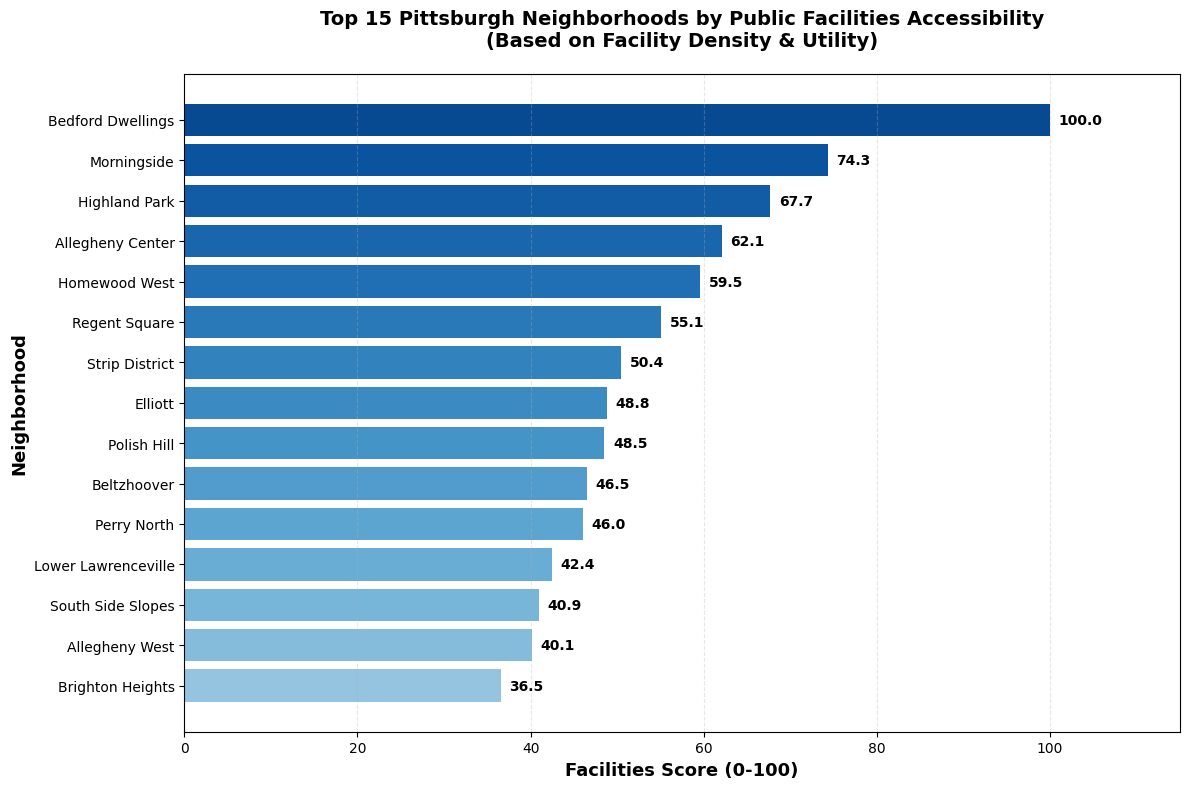

Saved: facilities_scatter.png


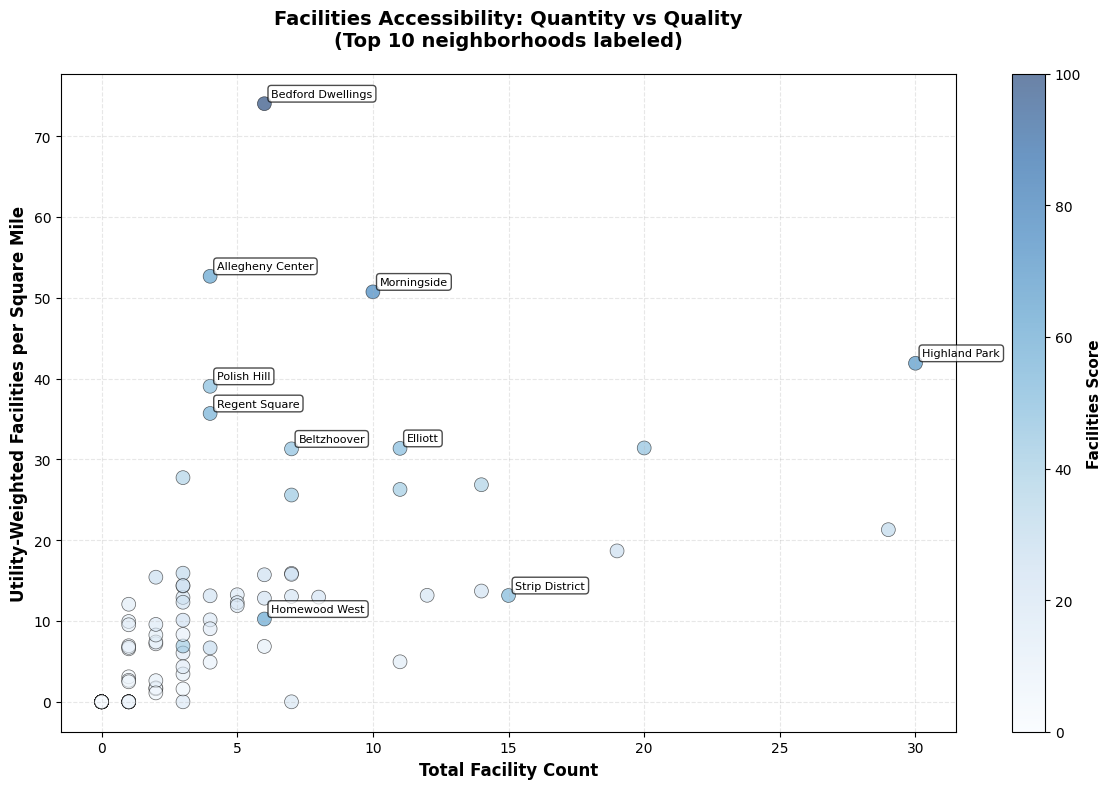

Saved: facilities_distribution_all.png


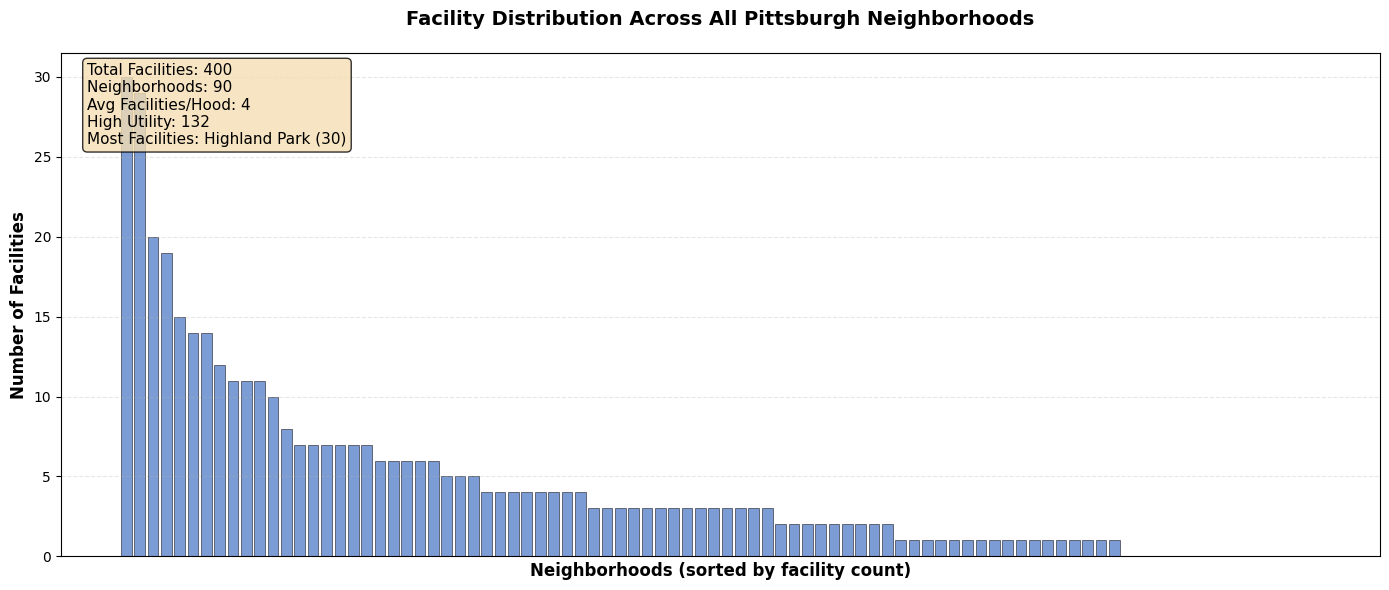

In [14]:
# visualize

# visual 1: horizontal bar chart of top 15 neighborhoods by facilities
fig, ax = plt.subplots(figsize=(12, 8))
top_15_sorted = merged.nlargest(15, 'facilities_score').sort_values('facilities_score')

colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_15_sorted)))
bars = ax.barh(top_15_sorted['hood'], top_15_sorted['facilities_score'], color=colors)

for i, (bar, value) in enumerate(zip(bars, top_15_sorted['facilities_score'])):
    ax.text(value + 1, i, f'{value:.1f}', 
            va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Facilities Score (0-100)', fontsize=13, fontweight='bold')
ax.set_ylabel('Neighborhood', fontsize=13, fontweight='bold')
ax.set_title('Top 15 Pittsburgh Neighborhoods by Public Facilities Accessibility\n(Based on Facility Density & Utility)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, max(top_15_sorted['facilities_score']) * 1.15)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(str(docs_dir / 'facilities_rankings.png'), dpi=300, bbox_inches='tight')
print("Saved: facilities_rankings.png")
plt.show()

# visual 2: facilities count vs utility scatter
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(merged['total_facilities'], 
                     merged['utility_per_sq_mi'],
                     c=merged['facilities_score'],
                     cmap='Blues',
                     s=100,
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)

top_10 = merged.nlargest(10, 'facilities_score')
for _, row in top_10.iterrows():
    ax.annotate(row['hood'], 
                (row['total_facilities'], row['utility_per_sq_mi']),
                fontsize=8,
                xytext=(5, 5),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.set_xlabel('Total Facility Count', fontsize=12, fontweight='bold')
ax.set_ylabel('Utility-Weighted Facilities per Square Mile', fontsize=12, fontweight='bold')
ax.set_title('Facilities Accessibility: Quantity vs Quality\n(Top 10 neighborhoods labeled)', 
             fontsize=14, fontweight='bold', pad=20)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Facilities Score', fontsize=11, fontweight='bold')

ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(str(docs_dir / 'facilities_scatter.png'), dpi=300, bbox_inches='tight')
print("Saved: facilities_scatter.png")
plt.show()

# visual 3: distribution of facilities across city
fig, ax = plt.subplots(figsize=(14, 6))

all_hoods = merged.sort_values('total_facilities', ascending=False)

ax.bar(range(len(all_hoods)), all_hoods['total_facilities'], 
       color='#4472C4', alpha=0.7, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Neighborhoods (sorted by facility count)', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Facilities', fontsize=12, fontweight='bold')
ax.set_title('Facility Distribution Across All Pittsburgh Neighborhoods', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks([])  # remove x-axis labels (too many neighborhoods)

textstr = f"Total Facilities: {merged['total_facilities'].sum():,.0f}\n"
textstr += f"Neighborhoods: {len(merged)}\n"
textstr += f"Avg Facilities/Hood: {merged['total_facilities'].mean():.0f}\n"
textstr += f"High Utility: {merged['high_utility_facilities'].sum():,.0f}\n"
textstr += f"Most Facilities: {all_hoods.iloc[0]['hood']} ({all_hoods.iloc[0]['total_facilities']:.0f})"

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(str(docs_dir / 'facilities_distribution_all.png'), dpi=300, bbox_inches='tight')
print("Saved: facilities_distribution_all.png")
plt.show()

## 1.6 Save results

In [15]:
output_df = merged[[
    'hood', 
    'total_facilities',
    'high_utility_facilities',
    'medium_utility_facilities',
    'low_utility_facilities',
    'sqmiles',
    'facilities_per_sq_mi',
    'utility_per_sq_mi',
    'facilities_score'
]].sort_values('facilities_score', ascending=False)

output_path = data_dir / 'facilities_scores.csv'
output_df.to_csv(str(output_path), index=False)
print(f"Saved: {output_path}")
print("\nFirst 10 rows of output:")
print(output_df.head(10))

Saved: /Users/valimir7/dev/pitt/cmpinf0010/final/data/facilities_scores.csv

First 10 rows of output:
                 hood  total_facilities  high_utility_facilities  \
3   Bedford Dwellings               6.0                      1.0   
13        Morningside              10.0                      4.0   
36      Highland Park              30.0                     12.0   
45   Allegheny Center               4.0                      3.0   
42      Homewood West               6.0                      0.0   
85      Regent Square               4.0                      1.0   
81     Strip District              15.0                      0.0   
87            Elliott              11.0                      4.0   
39        Polish Hill               4.0                      3.0   
26        Beltzhoover               7.0                      3.0   

    medium_utility_facilities  low_utility_facilities   sqmiles  \
3                         5.0                     0.0  0.175674   
13             